In [41]:
import torch
import torch.nn as nn
import os
import stim
import numpy as np
from tqdm import tqdm
from typing import List
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [42]:
@dataclass
class DEM_Matrices:
    check_matrix: torch.Tensor
    logical_matrix: torch.Tensor
    llrs: torch.Tensor

def DEM_to_matrices(DEM: stim.DetectorErrorModel) -> DEM_Matrices:

    priors = np.zeros(DEM.num_errors)
    check_matrix = np.zeros((DEM.num_detectors, DEM.num_errors))
    logical_matrix = np.zeros((DEM.num_observables, DEM.num_errors))

    e = 0

    for instruction in DEM.flattened():

        if instruction.type == "error":

            detectors: List[int] = []
            logicals: List[int] = []
            t: stim.DemTarget
            p = instruction.args_copy()[0]
            for t in instruction.targets_copy():
                if t.is_relative_detector_id():
                    detectors.append(t.val)
                elif t.is_logical_observable_id():
                    logicals.append(t.val)

            priors[e] = p
            check_matrix[detectors, e] = 1
            logical_matrix[logicals, e] = 1

            e += 1

        elif instruction.type == "detector":
            pass
        elif instruction.type == "logical_observable":
            pass
        else:
            raise NotImplementedError()

    check_matrix = torch.tensor(check_matrix, dtype=torch.int)
    logical_matrix = torch.tensor(logical_matrix, dtype=torch.int)
    priors = torch.tensor(priors, dtype=torch.float32)

    llrs = torch.log((1 - priors) / priors)

    return DEM_Matrices(
        check_matrix=check_matrix,
        logical_matrix=logical_matrix,
        llrs=llrs
    )

In [43]:
class Nbp(nn.Module):

    def __init__(self,
                 circuit: stim.Circuit=None,
                 matrices: DEM_Matrices=None,
                 layers: int = 20,
                 batch_size: int = 1,
                 loss_function: str = 'binary_cross_entropy',
                 weights: str = None):

        super().__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.layers = layers
        self.batch_size = batch_size
        self.loss_function = loss_function

        if circuit:

            self.circuit = circuit
            self.dem = self.circuit.detector_error_model(decompose_errors=False)

            self.matrices = DEM_to_matrices( self.dem )

            self.H = self.matrices.check_matrix.to(self.device)
            self.L = self.matrices.logical_matrix.to(self.device)
            self.llrs = self.matrices.llrs.to(self.device)

        else:

            self.H = matrices.check_matrix
            self.L = matrices.logical_matrix
            self.llrs = matrices.llrs

        self.m, self.n = self.H.size()

        if not weights:
            self.ini_weights_as_one()
        else:
            self.load_weights(weights)

        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus(beta=1.0, threshold=50)
        self.softmax = nn.Softmax(dim=0)

    def ini_weights_as_one(self):

        self.weights_llr = []
        self.weights_de = []

        self.marg_weights_llr = []
        self.marg_weights_de = []

        self.rhos = []
        self.residual_weights = []

        for _ in range(self.layers):

            self.weights_de.append(torch.ones_like(self.H, dtype=float, requires_grad=True, device=self.device))
            self.weights_llr.append(torch.ones_like(self.llrs, dtype=float, requires_grad=True, device=self.device))

            self.marg_weights_de.append(torch.ones_like(self.H, dtype=float, requires_grad=True, device=self.device))
            self.marg_weights_llr.append(torch.ones_like(self.llrs, dtype=float, requires_grad=True, device=self.device))

        self.residual_weights.append(torch.zeros(self.layers, dtype=float, requires_grad=True, device=self.device))

        self.rhos.append(torch.ones(self.layers, dtype=float, requires_grad=True, device=self.device))
        # with torch.no_grad():
        #     normalised_rhos = [rho / self.layers for rho in self.rhos]
        # self.rhos = normalised_rhos

    def save_weights(self, path: str):

        if not os.path.exists(path):
            os.makedirs(path)

        file_de = 'weights_de.pt'
        file_llr = 'weights_llr.pt'

        file_marg_de = 'marg_weights_de.pt'
        file_marg_llr = 'marg_weights_llr.pt'

        file_residuals = 'residual_weights.pt'
        file_rhos = 'rhos.pt'

        torch.save(self.weights_de, os.path.join(path, file_de))
        torch.save(self.weights_llr, os.path.join(path, file_llr))

        torch.save(self.marg_weights_de, os.path.join(path, file_marg_de))
        torch.save(self.marg_weights_llr, os.path.join(path, file_marg_llr))

        torch.save(self.residual_weights, os.path.join(path, file_residuals))
        torch.save(self.rhos, os.path.join(path, file_rhos))

        print(f'Weigths saved as {file_de}, {file_llr}, {file_marg_de}, {file_marg_llr}, {file_residuals}, {file_rhos} at {path}.')

    def load_weights(self, path: str):

        file_de = 'weights_de.pt'
        file_llr = 'weights_llr.pt'

        file_marg_de = 'marg_weights_de.pt'
        file_marg_llr = 'marg_weights_llr.pt'

        file_residuals = 'residual_weights.pt'
        file_rhos = 'rhos.pt'

        self.weights_de = torch.load(os.path.join(path, file_de))
        self.weights_llr = torch.load(os.path.join(path, file_llr))

        self.marg_weights_de = torch.load(os.path.join(path, file_marg_de))
        self.marg_weights_llr = torch.load(os.path.join(path, file_marg_llr))

        self.residual_weights = torch.load(os.path.join(path, file_residuals))
        self.rhos = torch.load(os.path.join(path, file_rhos))

    def update_error_nodes(self, incoming_messages, weights_llr, weights_de):

        outgoing_messages = torch.zeros((self.batch_size, self.m, self.n), dtype=float, device=self.device)

        weighted_messages = incoming_messages * weights_de

        outgoing_messages += self.H * self.llrs * weights_llr
        outgoing_messages += torch.sum(weighted_messages, dim=1, keepdim=True)
        outgoing_messages *= self.H
        outgoing_messages -= incoming_messages

        return outgoing_messages

    def update_detector_nodes(self, incoming_messages, syndromes):

        divider = torch.tanh(incoming_messages / 2)
        divider = torch.where(divider == 0, torch.tensor(1.0), divider)

        multiplicator = torch.pow(-1, syndromes) * self.H

        outgoing_messages = 2*torch.atanh(torch.prod(divider, dim=2, keepdim=True) / divider)
        outgoing_messages *= multiplicator

        return outgoing_messages

    def compute_beliefs(self, detector_to_error_messages, marg_weights_llr, marg_weights_de):

        weighted_messages = detector_to_error_messages * marg_weights_de
        beliefs = torch.sum(weighted_messages, dim=1)
        beliefs += self.llrs*marg_weights_llr

        return beliefs

    def infer_predictions(self, beliefs):

        predictions = torch.zeros_like(beliefs, dtype=float, device=self.device)
        predictions[beliefs < 0] = 1
        predictions = predictions.int()

        return predictions

    def soft_vectors(self, beliefs):
        return self.sigmoid(-beliefs)

    def loss(self, beliefs, errors):

        if self.loss_function == 'binary_cross_entropy':
            loss = self.softplus(beliefs)
            loss -= (1 - errors) * beliefs
            loss = torch.sum(loss, dim=1)

        if self.loss_function == 'He=s':
            e = errors + self.sigmoid(-beliefs)
            loss = self.H.double() @ e.T
            loss = torch.abs(torch.sin(np.pi * loss / 2))
            loss = torch.sum(loss, dim=0)

        if self.loss_function == '[HL]e=s':
            e = errors + self.sigmoid(-beliefs)
            H_L = torch.cat((self.H, self.L), dim=0)
            loss = H_L.double() @ e.T
            loss = torch.abs(torch.sin(np.pi * loss / 2))
            loss = torch.sum(loss, dim=0)

        return loss

    def forward(self, syndromes, errors):

        syndromes = syndromes.to(self.device)
        errors = errors.to(self.device)

        rhos_normalised = self.softmax(torch.cat(self.rhos)).squeeze()
        loss_array = torch.zeros((self.batch_size, self.layers), dtype=float, device=self.device)
        messages_en_to_dn = torch.zeros((self.batch_size, self.m, self.n), dtype=float, device=self.device)
        messages_dn_to_en = torch.zeros((self.batch_size, self.m, self.n), dtype=float, device=self.device)

        for i in range(self.layers):

            messages_en_to_dn = self.update_error_nodes(messages_dn_to_en, self.weights_llr[i], self.weights_de[i])
            residual_messages = self.residual_weights[0][i] * messages_dn_to_en
            messages_dn_to_en = self.update_detector_nodes(messages_en_to_dn, syndromes) + residual_messages
            beliefs = self.compute_beliefs(messages_dn_to_en, self.marg_weights_llr[i], self.marg_weights_de[i])
            loss_array[:, i] = self.loss(beliefs, errors) * rhos_normalised[i]

        loss_array = loss_array
        loss = torch.sum(loss_array, dim=1)
        loss = torch.sum(loss, dim=0) / self.batch_size

        return loss

    def decode(self, syndromes):

        messages_en_to_dn = torch.zeros((self.batch_size, self.m, self.n), dtype=float, device=self.device)
        messages_dn_to_en = torch.zeros((self.batch_size, self.m, self.n), dtype=float, device=self.device)

        for i in range(self.layers):

            messages_en_to_dn = self.update_error_nodes(messages_dn_to_en, self.weights_llr[i], self.weights_de[i])
            residual_messages = self.residual_weights[0][i] * messages_dn_to_en
            messages_dn_to_en = self.update_detector_nodes(messages_en_to_dn, syndromes) + residual_messages
            beliefs = self.compute_beliefs(messages_dn_to_en, self.marg_weights_llr[i], self.marg_weights_de[i])

        predictions = self.infer_predictions(beliefs)
        predictions = ( self.L @ predictions.T ) % 2

        return predictions

In [44]:
def circuit(p):
    circuit = stim.Circuit.generated(
                "surface_code:unrotated_memory_z",
                rounds=3,
                distance=3,
                after_clifford_depolarization=p,
                after_reset_flip_probability=p,
                before_measure_flip_probability=p,
                before_round_data_depolarization=p)
    return circuit

def optimization_step(decoder, syndromes, errors, optimizer: torch.optim.Optimizer):

   loss = decoder.forward(syndromes, errors)

   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   return loss.detach()

P = 0.005
LEARNING_RATE = 0.001
LAYERS = 20
BATCH_SIZE = 120
MINIBATCHES = 3000
LOSS_FUNCTION = 'He=s'
WEIGHTS_PATH = f'/content'

In [45]:
decoder = Nbp(circuit=circuit(P),
              layers=LAYERS,
              batch_size=BATCH_SIZE,
              loss_function=LOSS_FUNCTION)


parameters = decoder.weights_llr + decoder.weights_de + decoder.marg_weights_llr + decoder.marg_weights_de + decoder.rhos + decoder.residual_weights
optimiser = torch.optim.Adam(parameters, lr=LEARNING_RATE)
loss = torch.zeros(MINIBATCHES)
idx = 0

ps = np.arange(0.001, 0.01, 0.002)

with tqdm(total=MINIBATCHES) as pbar:
    for _ in range(MINIBATCHES):
        sampler = decoder.dem.compile_sampler()
        syndromes, logical_flips, errors = sampler.sample(shots=int(decoder.batch_size/(len(ps)+1)), return_errors=True)

        for p in ps:
            dem = circuit(p).detector_error_model(decompose_errors=False)
            sampler = dem.compile_sampler()
            temp_syndromes, temp_logical_flips, temp_errors = sampler.sample(shots=int(decoder.batch_size/(len(ps)+1)), return_errors=True)
            syndromes = np.concatenate((syndromes, temp_syndromes), axis=0)
            logical_flips = np.concatenate((logical_flips, temp_logical_flips), axis=0)
            errors = np.concatenate((errors, temp_errors), axis=0)

        syndromes = torch.from_numpy(syndromes).int()
        syndromes = torch.reshape(syndromes, (len(syndromes), len(syndromes[0]), 1))
        logical_flips = torch.from_numpy(logical_flips).int()
        errors = torch.from_numpy(errors).int()
        loss[idx]= optimization_step(decoder, syndromes, errors, optimiser)

        pbar.update(1)
        pbar.set_description(f"loss {loss[idx]:.16f}")
        idx += 1

    decoder.save_weights(WEIGHTS_PATH)
print('Training complete.\n')

loss 0.0193223059177399: 100%|██████████| 3000/3000 [10:32<00:00,  4.75it/s]

Weigths saved as weights_de.pt, weights_llr.pt, marg_weights_de.pt, marg_weights_llr.pt, residual_weights.pt, rhos.pt at /content.
Training complete.



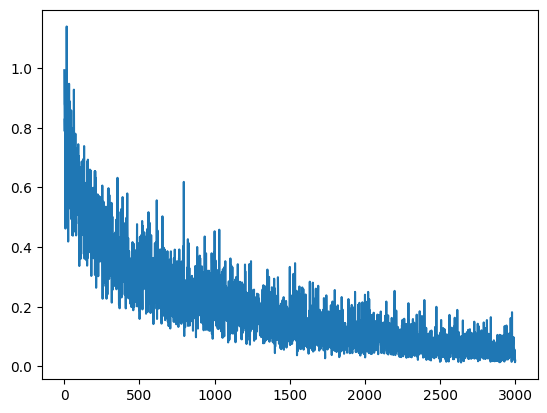

In [46]:
plt.plot(loss)

In [50]:
def plot_matrix_weights(tensor):
    iterations = np.arange(5, 20, 5)
    for i in iterations:
        plt.figure(figsize=(8, 8))
        plt.imshow(tensor[i].cpu().detach().numpy(), cmap='coolwarm', vmin=0.8, vmax=1.2, extent=[0,len(tensor[i][0]),0,len(tensor[i])], aspect=5)
        plt.colorbar(fraction=0.025)
        plt.title(f'Layer {i}', fontsize=25)
        plt.show()
        plt.clf()

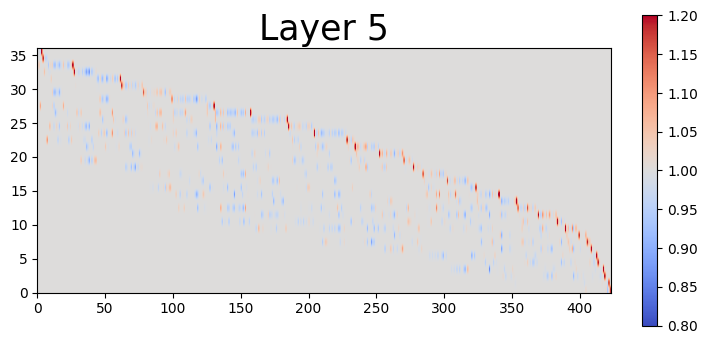

<Figure size 640x480 with 0 Axes>

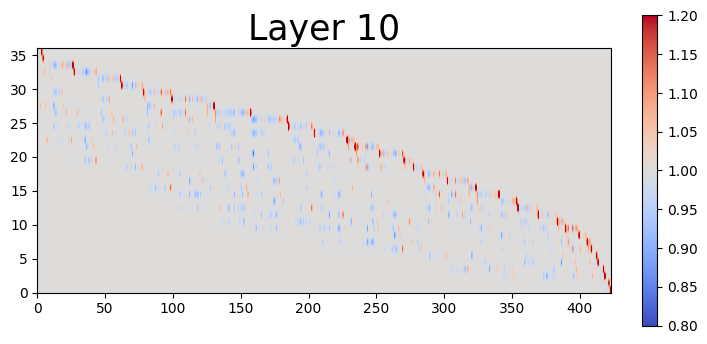

<Figure size 640x480 with 0 Axes>

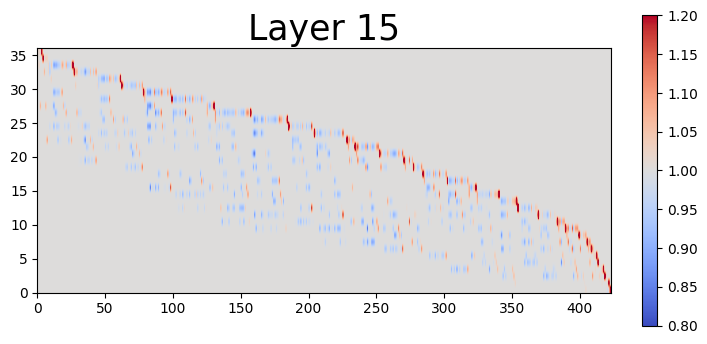

<Figure size 640x480 with 0 Axes>

In [52]:
plot_matrix_weights(decoder.weights_de)